In [ ]:
#!pip install wget

In [53]:
import pandas as pd
import os, sys
import numpy as np
import seaborn as sns
import gc
import warnings

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Embedding
from gensim.models import Word2Vec

from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import Input, Flatten, Dense, Conv1D, MaxPooling1D, GlobalMaxPool1D, SpatialDropout1D, \
                          UpSampling1D, LSTM, RepeatVector, TimeDistributed, GRU, Bidirectional, concatenate, \
                          Reshape, Dropout, BatchNormalization, GlobalAveragePooling1D, GlobalAveragePooling2D

from tensorflow.keras.utils import plot_model, to_categorical
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from tensorflow.keras.utils import to_categorical

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from custom_functions import norm_text, norm_brands, norm_images

pd.set_option('max_colwidth', 250)
warnings.filterwarnings(action='once')

In [54]:
main_dir = os.path.join(os.path.dirname(os.path.abspath('03_CandidateGeneration_20190422.ipynb')), 'custom_functions')
sys.path.insert(0, main_dir)
#sys.path

In [55]:
path = os.path.join('../../Data/')
path_text_encoders = os.path.join('../03_Preparacion_de_Datos/')
#EMbedding words = word2vec_model_v2
#Encoder = encoder_text_V1.h5

In [56]:
print (os.listdir(path_text_encoders))

['.ipynb_checkpoints', 'desktop.ini', 'encoder_text_V1.h5', 'encoder_text_V1.json', 'encoder_text_V2.h5', 'lda', 'lemmatization-es.txt', 'my_functions', 'PD_00_Preprocesado_20190309.ipynb', 'PD_01_GenerateCustomembedding_20190418.ipynb', 'PD_02_TextAutoencoder_20190418.ipynb', 'PD_98_LDA_Topics_0_20190313.ipynb', 'PD_99_Extra_20190421.ipynb', 'stopwords_catalan.txt', 'w2v_embedding_v1.h5', 'w2v_embedding_v1_1.h5', 'weights_encoder_text_V1.h5', 'word2vec_model_v1', 'word2vec_model_v2']


In [57]:
data = pd.read_csv(path + 'data_filtered_20190422.csv', sep = ';')
data_customers = pd.read_csv(path + 'customers_data_2.csv', sep = ';', nrows = 60000)
#data_text = pd.read_csv('Texto_PreProcesado_v2.csv', sep = ';')
#data_text = data_text[['item_id', 'text']]
data_customers.shape

(60000, 6)

In [58]:
data.head()

,item_id,availability_date,brand,category,name,price
0,A28233506,NaN,Woman Limited El Corte Inglés,"['Moda', 'Mujer', 'Abrigos']",Abrigo masculino con textura de mujer,"{'final': 199, 'currency': 'EUR'}"
1,A29054782,NaN,Woman Limited El Corte Inglés,"['Moda', 'Mujer', 'Abrigos']",Abrigo doble faz de mujer con cinturón a tono,"{'final': 149, 'currency': 'EUR'}"
2,A27354432,NaN,Woman El Corte Inglés,"['Moda', 'Mujer', 'Abrigos']",Abrigo largo de antelina de mujer Woman El Corte Inglés,"{'final': 89.99, 'currency': 'EUR'}"
3,A28302706,NaN,Lloyd's,"['Moda', 'Mujer', 'Abrigos']",Chaqueta térmica de mujer Lloyds con efecto cortavientos,"{'final': 129, 'currency': 'EUR'}"
4,A27435502,NaN,Lloyd's,"['Moda', 'Mujer', 'Abrigos']",Parka 100% algodón de mujer Lloyds con capucha,"{'final': 149, 'currency': 'EUR'}"


In [59]:
data_customers.head()

,date,item_id,brand,PRICE,customer_id,text
0,20190101,A26036172,Tintoretto,"27,99",0,Vestido de mujer Tintoretto de flores con lazada
1,20190101,A26036172,Tintoretto,"27,99",0,Vestido de mujer Tintoretto de flores con lazada
2,20190101,A26036172,Tintoretto,"27,99",0,Vestido de mujer Tintoretto de flores con lazada
3,20190101,A26036172,Tintoretto,"27,99",0,Vestido de mujer Tintoretto de flores con lazada
4,20190101,A26870590,Fórmula Joven,"19,99",0,Vestido laminado de mujer Fórmula Joven con escote en pico


In [60]:
%%time
#1min
brands = norm_brands.launch_normalizer(data_customers)
STOPWORDS_ALL =  norm_text.gen_stopwords(main_dir)
lemmatizer_inv = norm_text.get_lemmatizer(main_dir)
words = [word.split() for word in data_customers['text'].values]
for i in range(len(words)):
    data_customers['text'].values[i] = norm_text.normalize(words = words[i], p_brands = brands, 
                                                    STOPWORDS_ALL = STOPWORDS_ALL, 
                                                    lemmatizer_inv = lemmatizer_inv)


Marvel not in list


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\enric\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
C:\Users\enric\Google Drive\PROYECTOS\TFM_Motor de Recomendacion\Master\TFM_DNN_Recomendator\04_Modelado_y_Evaluacion\custom_functions\norm_text.py:18: ResourceWarning: unclosed file <_io.TextIOWrapper name='C:\\Users\\enric\\Google Drive\\PROYECTOS\\TFM_Motor de Recomendacion\\Master\\TFM_DNN_Recomendator\\04_Modelado_y_Evaluacion\\custom_functions\\stopwords_catalan.txt' mode='r' encoding='UTF-8'>
  STOPWORDS_CAT = open(path + '\stopwords_catalan.txt', 'r', encoding= 'UTF-8').read().split()


Wall time: 13.5 s


In [61]:
data_customers.head()

,date,item_id,brand,PRICE,customer_id,text
0,20190101,A26036172,tintoretto,"27,99",0,vestido mujer flor lazada
1,20190101,A26036172,tintoretto,"27,99",0,vestido mujer flor lazada
2,20190101,A26036172,tintoretto,"27,99",0,vestido mujer flor lazada
3,20190101,A26036172,tintoretto,"27,99",0,vestido mujer flor lazada
4,20190101,A26870590,fórmula joven,"19,99",0,vestido laminado mujer formula joven escote pico


In [62]:
data_customers.columns = data_customers.columns.str.strip()
data_customers.PRICE = data_customers.PRICE.apply(lambda x: x.strip())
data_customers.PRICE = data_customers.PRICE.str.replace('.', '')
data_customers.PRICE = data_customers.PRICE.str.replace(',', '.')
data_customers.PRICE = pd.to_numeric(data_customers['PRICE'])
data_customers.item_id = data_customers.item_id.apply(lambda x: x.strip())
data.item_id = data.item_id.apply(lambda x: x.strip())

In [63]:
data.columns = data.columns.str.strip()
data_customers['item_age'] = -1 * (data_customers['date'] - data['availability_date'])
data_customers['item_age'].fillna(0, inplace=True)

In [64]:
customers_unique = data_customers.customer_id.unique()
items_unique = data_customers.item_id.unique()
brand_unique = data_customers.brand.unique()

print (f'We have {len(customers_unique)} unique users and {len(items_unique)} unique items and {len(brand_unique)} unique brands')

We have 635 unique users and 20781 unique items and 1495 unique brands


### We need integer data to be able to feed the NN

In [65]:
customers_map = {i:val for i,val in enumerate(customers_unique)}
customers_map_inv = {val:i for i,val in enumerate(customers_unique)}

items_map = {i:val for i,val in enumerate(items_unique)}
items_map_inv = {val:i for i,val in enumerate(items_unique)}

brands_map = {i:val for i,val in enumerate(brand_unique)}
brands_map_inv = {val:i for i,val in enumerate(brand_unique)}

In [66]:
data_customers['customer_id_int'] = data_customers['customer_id'].map(customers_map_inv)
data_customers['item_id_int'] = data_customers['item_id'].map(items_map_inv)
data_customers['brand_id'] = data_customers['brand'].map(brands_map_inv)
data_customers.shape

(60000, 10)

In [67]:
data_score = data_customers.groupby(['customer_id_int', 'item_id_int']).size().to_frame('score').reset_index().sort_values(by = 'score',ascending = False)

In [68]:
data_final = pd.merge(data_customers, data_score, how = 'inner')
data_final.shape

(60000, 11)

In [69]:
#remove duplicates due to agrupation, if a customer bought a item 2 times i only want 1 row with score 2, instead of 2 rows
data_final.drop_duplicates(inplace=True)
data_final.dropna(how = 'any', inplace = True)

print(data_final.shape)
data_final.head()

(30484, 11)


,date,item_id,brand,PRICE,customer_id,text,item_age,customer_id_int,item_id_int,brand_id,score
0,20190101,A26036172,tintoretto,27.99,0,vestido mujer flor lazada,0.0,0,0,0,8
4,20190115,A26036172,tintoretto,27.99,0,vestido mujer flor lazada,0.0,0,0,0,8
8,20190101,A26870590,fórmula joven,19.99,0,vestido laminado mujer formula joven escote pico,0.0,0,1,1,4
12,20190103,MP_0659870_3014,gabrielle,76.10,1,abrigo mujer negro avalorios,0.0,1,2,2,1
13,20190103,A26011856,antea plus,84.50,1,abrigo largo mujer talla grande plus cuello alto,0.0,1,3,3,1


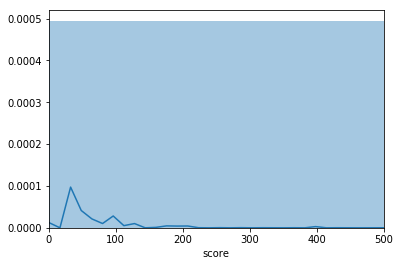

In [70]:
sns.distplot(data_score['score'], bins = 1).set(xlim = (0, 500));

## Vectorize sentences

In [71]:
MAX_NB_WORDS = 30_000 #decided by cumsum wordcount plot (Script 01)
MAX_SEQUENCE_LENGTH = 24 #decided by max words in a product (Script 00)
EMBEDDING_DIM = 100 #Same dim as our W2V embedding

all_text = data_final['text']
all_text = all_text.drop_duplicates (keep = False)

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, )
tokenizer.fit_on_texts(all_text)

data_sequences = tokenizer.texts_to_sequences(data_final['text'])
data_vec = pad_sequences(data_sequences, maxlen=MAX_SEQUENCE_LENGTH)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 9192 unique tokens.


In [72]:
len(data_vec)

30484

In [73]:
data_final.shape

(30484, 11)

In [74]:
modelWV = Word2Vec.load(path_text_encoders + 'word2vec_model_v2')
#encoder = load_model('encoder_text_V2.h5')

In [75]:
word_vectors = modelWV.wv
vocabulary_size = len(word_index) + 1
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))

for word, i in word_index.items():
    if word in modelWV:
        embedding_matrix[i] = modelWV[word]
    else:
        embedding_matrix[i] = np.random.rand(1, EMBEDDING_DIM)[0]
            

del(word_vectors)

embedding_layer = Embedding(input_dim = vocabulary_size,
                            output_dim = EMBEDDING_DIM,
                            input_length = MAX_SEQUENCE_LENGTH,
                            weights=[embedding_matrix],
                            name='w2v_embedding',
                            trainable=False)

C:\Users\enric\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  
C:\Users\enric\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  import sys


## Output

In [76]:
gc.enable()
del (data, data_score, data_customers, modelWV)
gc.collect()

6753

In [77]:
CAT_ITEMS = len(items_unique)

In [78]:
#train_df, test_df = train_test_split(data_final, test_size=0.1, random_state = 12)
#print(f'{len(train_df)} train rows, {len(test_df)} validate rows')

In [79]:
#train_items_encoded = to_categorical(train_df['item_id_int'], num_classes = CAT_ITEMS)
#test_items_encoded = to_categorical(test_df['item_id_int'], num_classes = CAT_ITEMS)
items_encoded = to_categorical(data_final['item_id_int'], num_classes = CAT_ITEMS)
print(items_encoded)

[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 0.]]


In [80]:
items_encoded.shape

(30484, 20781)

## Scale continuous data

In [81]:
#scaler = StandardScaler()
scaler = MinMaxScaler(feature_range = (0, 1))
data_to_scale1 = np.array([[x] for x in data_final['PRICE']])
data_to_scale2 = np.array([[x] for x in data_final['score']])
data_to_scale3 = np.array([[x] for x in data_final['item_age']])
scaled_data1 = scaler.fit_transform(data_to_scale1)
scaled_data2 = scaler.fit_transform(data_to_scale2)
scaled_data3 = scaler.fit_transform(data_to_scale3)

C:\Users\enric\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int32 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [82]:
data_final['score_original'] = data_final['score']
data_final['PRICE'] = scaled_data1.reshape(data_to_scale1.shape[0])
data_final['score'] = scaled_data2.reshape(data_to_scale2.shape[0])
data_final['item_age'] = scaled_data3.reshape(data_to_scale3.shape[0])

data_final['power_price'] = np.power(scaled_data1.reshape(data_to_scale1.shape[0]), 2)
data_final['power_score'] = np.power(scaled_data2.reshape(data_to_scale2.shape[0]), 2)
data_final['power_item_age'] = np.power(scaled_data3.reshape(data_to_scale3.shape[0]), 2)

data_final['sqrt_price'] = np.sqrt(scaled_data1.reshape(data_to_scale1.shape[0]))
data_final['sqrt_score'] = np.sqrt(scaled_data2.reshape(data_to_scale2.shape[0]))
data_final['sqrt_item_age'] = np.sqrt(scaled_data3.reshape(data_to_scale3.shape[0]))


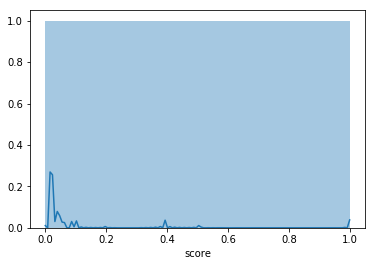

In [83]:
sns.distplot(data_final['score'], bins = 1);

In [84]:
data_final.to_csv('data_final_20190524.csv', index=False)

## Architecture

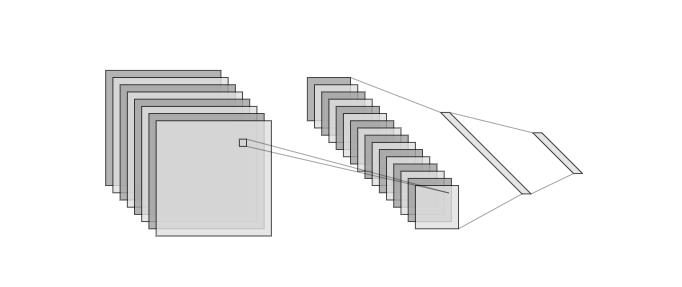

In [85]:
#img_encoder = load_model('full_encoder_v1.h5')

In [102]:
data_final.head(3)
print(data_final.shape)

(30484, 18)


In [103]:
user_id_input = Input(shape=[1], name='user')
item_id_input = Input(shape=[1], name='item')
brand_id_input = Input(shape = [1], name = 'brand')

price_input = Input(shape = [1], name = 'price')
score_input = Input(shape = [1], name = 'score')
item_age_input = Input(shape = [1], name = 'item_age')

price_power_input = Input(shape = [1], name = 'power_price')
score_power_input = Input(shape = [1], name = 'power_score')
item_age_power_input = Input(shape = [1], name = 'power_item_age')

price_sqrt_input = Input(shape = [1], name = 'sqrt_price')
score_sqrt_input = Input(shape = [1], name = 'sqrt_score')
item_age_sqrt_input = Input(shape = [1], name = 'sqrt_item_age')

#text_input = Input(shape=(MAX_SEQUENCE_LENGTH, EMBEDDING_DIM), name = 'text_input')

sequence_input = Input(shape = (MAX_SEQUENCE_LENGTH, ), name = 'text')

embedding_size = 20

user_embedding = Embedding(output_dim=embedding_size, input_dim = customers_unique.shape[0]+1,
                           input_length=1, name='user_embedding')(user_id_input)
item_embedding = Embedding(output_dim=embedding_size, input_dim = items_unique.shape[0]+1,
                           input_length=1, name='item_embedding')(item_id_input)
brand_embedding = Embedding(output_dim=embedding_size, input_dim = brand_unique.shape[0]+1,
                           input_length=1, name='brand_embedding')(brand_id_input)

text_embedding = Embedding(*embedding_matrix.shape, weights = [embedding_matrix], trainable = False)(sequence_input)

#text_embedding = encoder([sequence_input])

user_vecs = Reshape([embedding_size])(user_embedding)
item_vecs = Reshape([embedding_size])(item_embedding)
brand_vecs = Reshape([embedding_size])(brand_embedding)
#text_flat = Flatten()(text_embedding)
text_flat = Bidirectional(LSTM(128, dropout = 0.1, recurrent_dropout = 0.3))(text_embedding)

x1 = concatenate([user_vecs, item_vecs, brand_vecs, price_input, item_age_input, score_input,
                 price_power_input, score_power_input, item_age_power_input,
                 price_sqrt_input, score_sqrt_input, item_age_sqrt_input, text_flat], name = 'VECTOR_PRODUCTO')

x2 = Dropout(0.4)(x1)
x3 = Dense (256, activation = 'relu')(x2)
x4 = Dropout(0.3)(x3)
x5 = Dense(128, activation = 'relu')(x4)
x6 = Dropout(0.2)(x5)
x7 = Dense(64, activation = 'relu')(x6)
x8 = Dropout(0.2)(x7)

output = Dense(CAT_ITEMS, activation = 'softmax' )(x8)

model = Model(inputs=[user_id_input, item_id_input, brand_id_input, price_input, sequence_input, item_age_input, score_input,
                     price_power_input, score_power_input, item_age_power_input,
                     price_sqrt_input, score_sqrt_input, item_age_sqrt_input], 
              outputs = output)

model.compile(loss = 'categorical_crossentropy',
              optimizer = 'rmsprop',
              metrics = ['acc'])

model.summary()

C:\Users\enric\Anaconda3\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
item (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
brand (InputLayer)              (None, 1)            0                                            
__________________________________________________________________________________________________
text (InputLayer)               (None, 24)           0                                            
__________________________________________________________________________________________________
user_embed

In [104]:
def plot_training(history):
    plt.plot(history.history['acc'])
    #plt.plot(history.history['val_acc'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    #plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

In [105]:
history = model.fit([data_final['customer_id_int'], data_final['item_id_int'], 
                     data_final['brand_id'], data_final['PRICE'],
                     data_vec, data_final['item_age'], data_final['score'],
                     data_final['power_price'], data_final['power_score'], data_final['power_item_age'],
                     data_final['sqrt_price'], data_final['sqrt_score'], data_final['sqrt_item_age']],
                     items_encoded,
                     epochs = 10, #validation_split = 0.1,
                     batch_size = 256, verbose = 1,
                     shuffle = True)

#Epoch 5 = loss = 7.12 & acc = 0.0505
#Epoch 10 = loss = 5.16 & acc = 0.1152

Epoch 1/10
30484/30484 [==============================] - 46s 2ms/sample - loss: 9.8539 - acc: 0.0025
Epoch 2/10
30484/30484 [==============================] - 43s 1ms/sample - loss: 9.4933 - acc: 0.0046
Epoch 3/10
30484/30484 [==============================] - 43s 1ms/sample - loss: 9.0873 - acc: 0.0094
Epoch 4/10
30484/30484 [==============================] - 47s 2ms/sample - loss: 8.6490 - acc: 0.0154
Epoch 5/10
30484/30484 [==============================] - 50s 2ms/sample - loss: 8.2479 - acc: 0.0205
Epoch 6/10
30484/30484 [==============================] - 46s 2ms/sample - loss: 7.9321 - acc: 0.0278
Epoch 7/10
30484/30484 [==============================] - 51s 2ms/sample - loss: 7.6720 - acc: 0.0323
Epoch 8/10
30484/30484 [==============================] - 47s 2ms/sample - loss: 7.4538 - acc: 0.0382
Epoch 9/10
30484/30484 [==============================] - 45s 1ms/sample - loss: 7.2906 - acc: 0.0429
Epoch 10/10
30484/30484 [==============================] - 48s 2ms/sample - loss: 

In [106]:
model.save('candidate_generation_20190524')

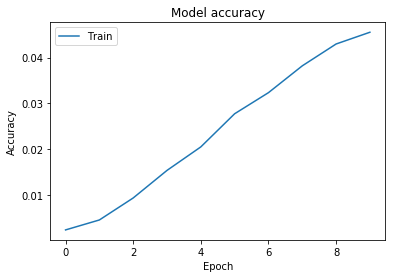

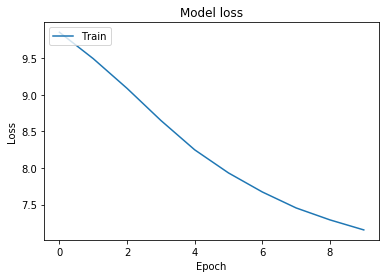

In [107]:
plot_training(history)

---

In [ ]:
test_pred = model.predict([data_final['customer_id_int'], data_final['item_id_int'], 
                     data_final['brand_id'], data_final['PRICE'],
                     data_vec, data_final['item_age'], data_final['score'],
                     data_final['power_price'], data_final['power_score'], data_final['power_item_age'],
                     data_final['sqrt_price'], data_final['sqrt_score'], data_final['sqrt_item_age']],
                     verbose = 1)

In [ ]:
test_pred.shape

In [ ]:
test_pred[:10]

In [ ]:
CUSTOMER = 101

In [ ]:
top10 = test_pred[CUSTOMER].argsort()[-1000:][::-1] #items positions

In [ ]:
items_unique[top10][:10]

In [ ]:
data = pd.read_csv(path + 'data_filtered_20190422.csv', sep = ';')

In [ ]:
data[data['item_id'].isin(items_unique[top10])]

In [ ]:
data_final.loc[CUSTOMER]['customer_id_int']

In [ ]:
data_final[data_final.customer_id_int == 101]

In [ ]:
#del data
#gc.collect()